# 5.2. FLAX Library and XLA Compiler

> **Author**: Gustavo Leite / **Date**: March 2022.

In this lecture we will take a look at how can we actually use JAX to create fast and scalable machine learning models. We will begin by discussing the convolution operators available in JAX and then we will turn our attention to the FLAX and OPTAX libraries for ML, built on top of JAX.

In [1]:
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

<hr />

## Beyond `jax.numpy`

Beside the `jax.numpy` submodule, there is also the `jax.scipy` module that implements a subset of functions from the [SciPy](https://scipy.org/) library.

In [2]:
import jax.numpy as jnp
import jax.scipy as jsp

In particular, the `jax.scipy.linalg` module provides many common operations on matrices, like:

- Determinants (`det`);
- Solving linear systems $A \cdot x = b$ for unknown $x$ (`solve`, `solve_triangular`);
- Factorizations (`lu`, `cholesky`, `polar`, `qr`, `schur`, `svd`);
- Inverse (`inv`);
- and more.

In [3]:
M = jnp.array([[1, 3],
               [5, 2]])

assert sp.linalg.det(M) == -13.0

For a complete reference, check the JAX documentation of the [`scipy` module](https://jax.readthedocs.io/en/latest/jax.scipy.html).

On the same vein, JAX has a lower-level interface called LAX, which resembles `jax.numpy` but with harder contraints on types. In practice, all `jax.numpy` operations are implemented in terms of LAX primitives.

In [4]:
from jax import lax

For example, operations on mixed types (*e.g.* floating points and integers) are allowed in JAX Numpy but are forbidden in LAX.

In [5]:
from sys import stderr

# This is allowed...
assert jnp.add(1.0, 1) == 2.0
#      =======

try:
    # ...while this is not! 
    print(lax.add(1.0, 1))
    #     =======
except TypeError as error:
    print(f"Error: {error}", file=stderr)

Error: lax.add requires arguments to have the same dtypes, got float32, int32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).


<hr />

## Convolutions in JAX

Convolutional operators are a quintessential part of many successful machine learning models. In this section we will preset three different ways users of the JAX library can execute convolution operations.

### Numpy 1-D Convolutions

The JAX Numpy API only has primitives for executing one dimensional convolutions. We will show how to convolve higher-rank tensors in a bit.

In [6]:
import jax
import jax.numpy as jnp

key = jax.random.PRNGKey(0)

First, let's create some dummy data we can work with.

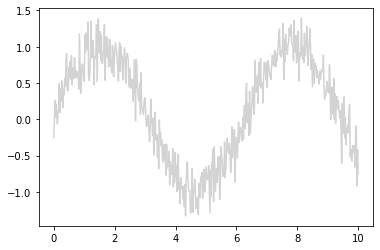

In [7]:
key, rng = jax.random.split(key)

x = jnp.linspace(0, 10, 500)
y = jnp.sin(x) + 0.2 * jax.random.normal(rng, shape=x.shape)

plt.plot(x, y, 'lightgray')

We will convolve the `y` array with a kernel do smooth the function.

In [8]:
kernel = jnp.ones(65) / 65.

print(f"Shape = {kernel.shape}")
print(kernel)

Shape = (65,)
[0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462]


The function we are looking for is `jax.numpy.convolve`, that mimics the original `numpy.convolve` function. The mode refers to how we wish to handle the padding: the output array must have the `same` size as the original, therefore padding is added automatically. The result is a smooothed-out version of the original data!

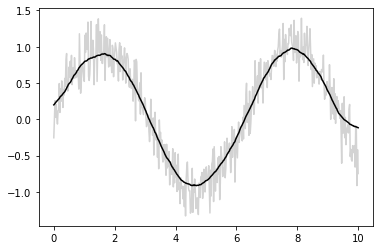

In [9]:
y_smooth = jnp.convolve(y, kernel, mode='same')
#                                  ===========

plt.plot(x, y, 'lightgray')
plt.plot(x, y_smooth, 'black')

Inspecting the JAXPR of `jnp.convolve` we see many things happening, such as:

- Change the shape of data and kernel (`broadcast_in_dim`);
- The convolution function itself (`conv_general_dilated`):
  + Using strides of 1;
  + With 64 elements of padding on each side.

In [10]:
jax.make_jaxpr(jnp.convolve)(y, kernel)

{ lambda ; a:f32[500] b:f32[65]. let
    c:f32[564] = xla_call[
      call_jaxpr={ lambda ; d:f32[500] e:f32[65]. let
          f:f32[564] = xla_call[
            call_jaxpr={ lambda ; g:f32[500] h:f32[65]. let
                i:f32[65] = xla_call[
                  call_jaxpr={ lambda ; j:f32[65]. let
                      k:f32[65] = rev[dimensions=(0,)] j
                    in (k,) }
                  name=_flip
                ] h
                l:f32[1,1,500] = broadcast_in_dim[
                  broadcast_dimensions=(2,)
                  shape=(1, 1, 500)
                ] g
                m:f32[1,1,65] = broadcast_in_dim[
                  broadcast_dimensions=(2,)
                  shape=(1, 1, 65)
                ] i
                n:f32[1,1,564] = conv_general_dilated[
                  batch_group_count=1
                  dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2), rhs_spec=(0, 1, 2), out_spec=(0, 1, 2))
                  feature_group_count=1
          

### Scipy N-D Convolutions

Let's try to smooth an image using the Scipy API. We will load an image of a raccoon to test the functinos!

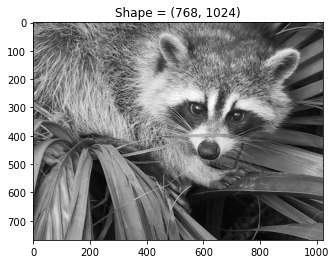

In [11]:
image = sp.misc.face().mean(-1)
image = jax.device_put(image)

plt.title(f'Shape = {image.shape}')
plt.imshow(image, cmap='binary_r')

This is another smoothing kernel, in 2 dimensions this time.

In [12]:
# 31x31 smoothing kernel
kernel = jnp.ones((31, 31)) / (31. ** 2.)

You may use either `jax.scipy.signal.convolve2d` (2 dimensions) or `jax.scipy.signal.convolve` (N dimensions). The result should be a blurred version of the raccoon.

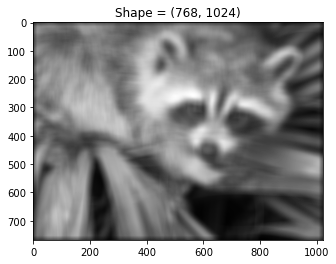

In [13]:
smooth = jsp.signal.convolve2d(image, kernel, mode='same')

plt.title(f'Shape = {smooth.shape}')
plt.imshow(smooth, cmap='binary_r')

The JAXPR of this function looks very similar to `jax.numpy.convolve`.

In [14]:
jax.make_jaxpr(jsp.signal.convolve2d)(image, kernel)

{ lambda ; a:f32[768,1024] b:f32[31,31]. let
    c:f32[31,31] = xla_call[
      call_jaxpr={ lambda ; d:f32[31,31]. let
          e:f32[31,31] = rev[dimensions=(0, 1)] d
        in (e,) }
      name=_flip
    ] b
    f:f32[1,1,768,1024] = broadcast_in_dim[
      broadcast_dimensions=(2, 3)
      shape=(1, 1, 768, 1024)
    ] a
    g:f32[1,1,31,31] = broadcast_in_dim[
      broadcast_dimensions=(2, 3)
      shape=(1, 1, 31, 31)
    ] c
    h:f32[1,1,798,1054] = conv_general_dilated[
      batch_group_count=1
      dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 1, 2, 3), rhs_spec=(0, 1, 2, 3), out_spec=(0, 1, 2, 3))
      feature_group_count=1
      lhs_dilation=(1, 1)
      lhs_shape=(1, 1, 768, 1024)
      padding=((30, 30), (30, 30))
      precision=None
      preferred_element_type=None
      rhs_dilation=(1, 1)
      rhs_shape=(1, 1, 31, 31)
      window_strides=(1, 1)
    ] f g
    i:bool[] = lt 0 0
    j:i32[] = add 0 1
    k:i32[] = select_n i 0 j
    l:i32[] = convert_eleme

### JAX LAX Convolutions

The most general convolution operations are found in the `jax.lax` package.

In [15]:
from jax import lax

We will load the raccoon image again, now with colors.

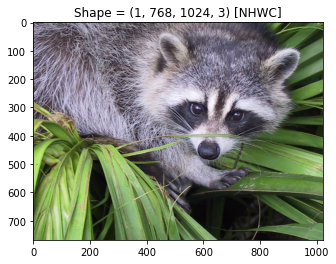

In [16]:
image = sp.misc.face()[jnp.newaxis, :, :, :] / 255.

plt.title(f'Shape = {image.shape} [NHWC]')
plt.imshow(image[0])

The following cell setup a smoothing kernel. It basically smooths each channel independently and combine the results into a new image.

In [17]:
kernel = jnp.zeros((3, 3, 31, 31), dtype=jnp.float32)
ones = jnp.ones((31, 31)) / (31. ** 2.)

kernel = kernel.at[0, 0, :, :].set(ones)
kernel = kernel.at[1, 1, :, :].set(ones)
kernel = kernel.at[2, 2, :, :].set(ones)

print(f"Kernel shape = {kernel.shape} [OIHW]")

Kernel shape = (3, 3, 31, 31) [OIHW]


JAX convolutions expect the NCHW model, but our input is represented as NHWC. Thefore we create a `ConvDimensionNumbers` object to represent the layout of the inputs LHS and RHS, and the layout we expect on the output.

In [18]:
dim = lax.conv_dimension_numbers(
    image.shape,
    kernel.shape,
    ('NHWC', 'OIHW', 'NHWC')
#    ======  ======  ======
#     LHS     RHS     OUT
)

dim

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(0, 1, 2, 3), out_spec=(0, 3, 1, 2))

Finally, we invoke LAX directly using the function `conv_general_dilated`. Notice that we have control over the strides, padding, and dilation (not shown here).

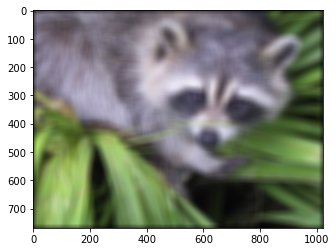

In [19]:
smooth = lax.conv_general_dilated(
    lhs=image,
    rhs=kernel,
    window_strides=(1, 1),
    padding='same',
    dimension_numbers=dim
)

plt.imshow(smooth[0])

Because LAX operations are lower level, no preprocessing occur like Numpy and Scipy convolutions. The user must take care of adjusting the shape and layout of the inputs explitly.

In [20]:
def convolve(image, kernel):
    """Helper function."""
    return lax.conv_general_dilated(
        lhs=image,
        rhs=kernel,
        window_strides=(1, 1),
        padding='same',
        dimension_numbers=dim
    )

jax.make_jaxpr(convolve)(image, kernel)

{ lambda ; a:f32[1,768,1024,3] b:f32[3,3,31,31]. let
    c:f32[1,768,1024,3] = conv_general_dilated[
      batch_group_count=1
      dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(0, 1, 2, 3), out_spec=(0, 3, 1, 2))
      feature_group_count=1
      lhs_dilation=(1, 1)
      lhs_shape=(1, 768, 1024, 3)
      padding=((15, 15), (15, 15))
      precision=None
      preferred_element_type=None
      rhs_dilation=(1, 1)
      rhs_shape=(3, 3, 31, 31)
      window_strides=(1, 1)
    ] a b
  in (c,) }

<hr />

## FLAX & OPTAX

[FLAX](https://github.com/google/flax) is a Neural Network library developed by Google on top of JAX. It provides high-level constructs for ML Operators. Its API is somewhat similar to Keras. FLAX, however, do not provide primitives for training networks. For that, we will use [OPTAX](https://github.com/deepmind/optax), developed by the DeepMind team also on top of JAX. They follow the same functional programming style and compose well.

In [21]:
import flax.linen as nn  # For neural network operators
import optax             # For optimizers like SGD, Adam, RMSProp, ...

# We need this to hold the training state
from flax.training.train_state import TrainState

## Define the model

Let us train a CNN on the MNIST dataset using FLAX/OPTAX. We start by defining our network model using FLAX operator primitives in the [`flax.linen`](https://flax.readthedocs.io/en/latest/flax.linen.html) module.

- [Conv](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.Conv.html): general convolutions;
- [Dense](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.Dense.html): fully connected layer;
- and others...

In [22]:
class CNN(nn.Module):
#         ========= Base class provided by FLAX.
    
    @nn.compact
#   =========== Decorator that generates other useful functions.
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

## Define Loss Function

Next, we will adopt the cross-entropy function as our loss measure for our network. This function is given by the following expression:

$$
    C = -\frac{1}{n} \sum_x \left[ y \cdot \ln(\hat{y}) \right]
$$

Implementing such function with JAX is as simple as:

In [23]:
def cross_entropy_loss(*, y_pred, y_label):
    """Compute cross-entropy loss given the activations and ground-truth labels."""
    # Labels are numeric, convert them to one hot
    y_label_one_hot = jax.nn.one_hot(y_label, num_classes=10)
    # Return cross-entropy loss
    return -jnp.mean(jnp.sum(y_label_one_hot * y_pred, axis=-1))

## Metrics Computation

In terms of metrics, we will observe the loss and accuracy over time.

In [24]:
def compute_metrics(*, y_pred, y_label):
    """Compute metrics for a subset of data."""
    return {
        'loss': cross_entropy_loss(y_pred=y_pred, y_label=y_label),
        'accuracy': jnp.mean(jnp.argmax(y_pred, -1) == y_label),
    }

## Load MNIST Dataset

We will use Tensorflow to load the MNIST dataset.

In [25]:
import tensorflow_datasets as tfds

In [26]:
def load_mnist():
    """Load MNIST dataset using Tensorflow."""
    
    # Download data
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    
    # Create datasets
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    
    # Normalize images between 0.0 and 1.0
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    
    return train_ds, test_ds

Let us load the datasets and get an overview of their shapes...

In [27]:
# Load datasets
train_ds, test_ds = load_mnist()

# Get overview of both datasets
print("Train dataset:", jax.tree_map(lambda x: (x.shape, x.dtype), train_ds))
print(" Test dataset:", jax.tree_map(lambda x: (x.shape, x.dtype), test_ds))

Train dataset: {'image': ((60000, 28, 28, 1), dtype('float32')), 'label': ((60000,), dtype('int64'))}
 Test dataset: {'image': ((10000, 28, 28, 1), dtype('float32')), 'label': ((10000,), dtype('int64'))}


...and display some example images.

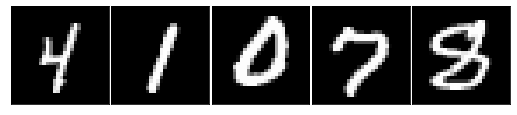

In [28]:
fig, axs = plt.subplots(ncols=5, figsize=(9, 1.8))
fig.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axs):
    ax.imshow(train_ds['image'][i], cmap='binary_r', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

## Create Training State

Now it is time to define a function that will create the training state.

In [29]:
def create_train_state(rng, learning_rate, momentum):
    # Instantiate model
    cnn = CNN()
    # Initialize parameters
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    # Instantiate optimizer
    tx = optax.sgd(learning_rate, momentum)
    # Instantiate train state
    return TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

## Training Step

Now it is time to define a training step on a single batch of images. This function will be executed thousands of times during the training loop, therefore it is interesting to JIT compile it. Do remember that by JIT compiling this function we are also compling everything that is called by `train_step`, in particular, `CNN.apply` and `loss_fn` will also be compiled.

In [30]:
@jax.jit
def train_step(state, batch):
    """Perform a training step on a batch of images and update state."""
    
    def loss_fn(params):
        """Feed forward current batch, returns loss and
        activations of the last layer."""
        
        # Apply (i.e. predict) the model on a batch of images
        y_pred = CNN().apply({'params': params}, batch['image'])
        # Compute loss from the predictions
        loss = cross_entropy_loss(y_pred=y_pred, y_label=batch['label'])
        
        return loss, y_pred
    
    # Compute gradient (and value) of loss function
    (_, y_pred), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    # Update model parameters using gradients (!)
    state = state.apply_gradients(grads=grads)
    # Compute metrics for this batch
    metrics = compute_metrics(y_pred=y_pred, y_label=batch['label'])
    
    return state, metrics

## Evaluation Step

Beyond the training step, we need an evaluation step to check how the accuracy is going during training.

In [31]:
@jax.jit
def eval_step(params, batch):
    """Evaluate model on a testing batch."""
    y_pred = CNN().apply({'params': params}, batch['image'])
    return compute_metrics(y_pred=y_pred, y_label=batch['label'])

## Training Loop

We arrive at the training loop where we divide the dataset in mini-batches and perform a training step for each batch. The loss and accuracy are accumulated so that we can update the weights and biases later.

In [32]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train the model for an entire epoch."""
    
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size
    
    # Shuffle the dataset and divide it into mini-batches
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    # Perform a train step in each batch and save metrics
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)
    
    # Average metrics for each batch
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    
    # Retrieve loss and accuracy
    loss = epoch_metrics_np['loss']
    acc = epoch_metrics_np['accuracy'] * 100
    
    return state, loss, acc

## Evaluation Function

Next we define a function to evaluate the entire model and summarize the metrics.

In [33]:
def eval_model(params, test_ds):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

## Initialization

We are almost ready to begin training! We just need to instantiate our training state.

In [34]:
# Create random number generator
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# Create train state
learning_rate = 0.1
momentum = 0.9
state = create_train_state(init_rng, learning_rate, momentum)

print(jax.tree_map(lambda x: x.shape, state.params))

FrozenDict({
    Conv_0: {
        bias: (32,),
        kernel: (3, 3, 1, 32),
    },
    Conv_1: {
        bias: (64,),
        kernel: (3, 3, 32, 64),
    },
    Dense_0: {
        bias: (256,),
        kernel: (3136, 256),
    },
    Dense_1: {
        bias: (10,),
        kernel: (256, 10),
    },
})


## Training the model

Let's begin training. We will use 10 epochs and a mini-batch size of 32.

In [35]:
num_epochs = 10
batch_size = 32

for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, loss, acc = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    test_loss, test_acc = eval_model(state.params, test_ds)
    
    print(f"EPOCH {epoch:02} -----------------------------")
    print(f">> Train:  loss={loss:.8f}  acc={acc:.2f}%")
    print(f">>  Test:  loss={test_loss:.8f}  acc={test_acc*100:.2f}%")

2022-06-23 09:31:17.232634: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-23 09:31:17.602176: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


EPOCH 01 -----------------------------
>> Train:  loss=0.14094460  acc=95.75%
>>  Test:  loss=0.05558632  acc=98.30%
EPOCH 02 -----------------------------
>> Train:  loss=0.04730429  acc=98.54%
>>  Test:  loss=0.04038892  acc=98.72%
EPOCH 03 -----------------------------
>> Train:  loss=0.03554752  acc=98.88%
>>  Test:  loss=0.03368211  acc=98.81%
EPOCH 04 -----------------------------
>> Train:  loss=0.02532800  acc=99.21%
>>  Test:  loss=0.04316162  acc=98.71%
EPOCH 05 -----------------------------
>> Train:  loss=0.02075484  acc=99.37%
>>  Test:  loss=0.03908233  acc=98.88%
EPOCH 06 -----------------------------
>> Train:  loss=0.01637389  acc=99.47%
>>  Test:  loss=0.03884124  acc=98.90%
EPOCH 07 -----------------------------
>> Train:  loss=0.01457682  acc=99.58%
>>  Test:  loss=0.03563010  acc=98.98%
EPOCH 08 -----------------------------
>> Train:  loss=0.01581625  acc=99.54%
>>  Test:  loss=0.04276372  acc=98.92%
EPOCH 09 -----------------------------
>> Train:  loss=0.0124026

Just to se it in action, we will predict the model on an input it has never seen during training.

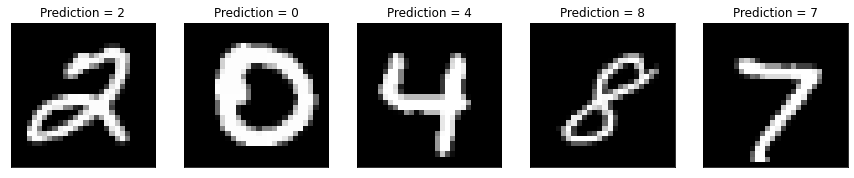

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axs):
    # Reshape image
    image = test_ds['image'][i]
    image = image.reshape((1, *image.shape))
    # Predict using trained params
    activations = CNN().apply({'params': state.params}, image)
    prediction = np.argmax(activations)
    # Display image and prediction
    ax.imshow(image[0], cmap='binary_r')
    ax.set_title(f'Prediction = {prediction}')
    ax.set_xticks([])
    ax.set_yticks([])

<hr />

<center style="font-size: 14pt; font-weight: bold;">
    That's all folks!
</center>